
# Detecção de Fraudes em Cartões de Crédito com Rede Neural e Ajuste de Hiperparâmetros

Este notebook implementa um fluxo completo para detecção de fraudes usando uma rede neural (TensorFlow/Keras), com avaliação por métricas (Precisão, Recall, F1-score e AUC-ROC) e ajuste de hiperparâmetros via **RandomizedSearchCV** e **GridSearchCV** (scikit-learn + scikeras). 



## Sumário do que será feito

1. Download e carregamento do dataset a partir do Google Drive (via `gdown`).  
2. Preparação dos dados e divisão *estratificada* em treino e teste.  
3. Modelo **base** de rede neural com *early stopping* e `class_weight` para lidar com desbalanceamento.  
4. Cálculo das métricas no teste: **accuracy**, **precision**, **recall**, **F1** e **AUC-ROC**.  
5. Ajuste de hiperparâmetros com **Random Search** e, em seguida, **Grid Search** em torno do melhor resultado.  
6. Reavaliação do melhor modelo no teste, comparação com o modelo base e geração de gráficos (curva ROC).  
7. Registro e salvamento dos resultados.  



## 1) Download do dataset

O dataset será baixado via **gdown**, usando o `doc_id` fornecido pelo enunciado.


In [3]:

import os

arquivo_destino_colab = "dataset.csv"
doc_id = "1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl"

# Baixa o arquivo do Google Drive
try:
    import gdown
    URL = f"https://drive.google.com/uc?id={doc_id}"
    gdown.download(URL, arquivo_destino_colab, quiet=False)
    assert os.path.exists(arquivo_destino_colab), "Falha no download: arquivo não encontrado."
    print("Download concluído:", os.path.getsize(arquivo_destino_colab), "bytes")
except Exception as e:
    print("Aviso: não foi possível baixar o dataset aqui. Rode esta célula no Colab com internet.")
    print("Erro:", repr(e))


Downloading...
From (original): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl
From (redirected): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl&confirm=t&uuid=8824501d-9f8b-4e19-b840-1ca0b43ecb4e
To: c:\Users\psant\Downloads\dataset.csv
100%|██████████| 151M/151M [01:09<00:00, 2.17MB/s] 

Download concluído: 150828752 bytes



## 2) Carregamento e checagens iniciais

Aqui são carregados os dados, inspecionadas as colunas e feita uma análise rápida do desbalanceamento da variável alvo (`Class`).


In [4]:

import pandas as pd

df = pd.read_csv(arquivo_destino_colab)
print("Dimensões:", df.shape)
print("Colunas:", list(df.columns))

display(df.head())

# Checa valores ausentes
print("\nValores ausentes por coluna:")
print(df.isna().sum())

# Estatísticas da coluna alvo (assumindo 'Class' como 0=normal, 1=fraude)
if "Class" in df.columns:
    print("\nDistribuição da classe:")
    print(df["Class"].value_counts(normalize=False))
    print("\nProporção da classe (%):")
    print((df["Class"].value_counts(normalize=True) * 100).round(4))
else:
    raise ValueError("A coluna 'Class' não foi encontrada no dataset. Verifique o arquivo.")


Dimensões: (284807, 31)
Colunas: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Valores ausentes por coluna:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Distribuição da classe:
Class
0    284315
1       492
Name: count, dtype: int64

Proporção da classe (%):
Class
0    99.8273
1     0.1727
Name: proportion, dtype: float64



## 3) Divisão treino/teste e preparação

É feita uma divisão estratificada para manter a proporção de fraudes no treino e teste. Usa-se um `Pipeline` com `StandardScaler` seguido de um classificador Keras (via `scikeras`) para evitar vazamento de dados.


In [5]:

import numpy as np
from sklearn.model_selection import train_test_split

# Separa X e y
X = df.drop(columns=["Class"]).values
y = df["Class"].values

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamanhos:")
print("Treino:", X_train.shape, "Teste:", X_test.shape)


Tamanhos:
Treino: (227845, 30) Teste: (56962, 30)



## 4) Modelo base de Rede Neural (Keras)

O modelo base utiliza camadas densas com `ReLU`, `dropout` leve, regularização L2 e **early stopping**.  
Como há desbalanceamento de classes, são aplicados **pesos de classe** (`class_weight`) proporcionais à frequência.


In [7]:

import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, optimizers, losses, metrics
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Função construtora do modelo
def build_model(
    input_dim=None,
    neurons=64,
    layers_count=2,
    dropout=0.2,
    l2_reg=1e-4,
    learning_rate=1e-3
):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for _ in range(layers_count):
        model.add(layers.Dense(neurons, activation="relu",
                               kernel_regularizer=regularizers.l2(l2_reg)))
        if dropout and dropout > 0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation="sigmoid"))
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[metrics.AUC(name="auc")])
    return model

# Pesos de classe
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {cls: float(w) for cls, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

# Pipeline: scaler -> KerasClassifier
base_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KerasClassifier(
        model=build_model,
        epochs=40,
        batch_size=512,
        verbose=0,
        # Hiperparâmetros do modelo (defaults do baseline)
        neurons=64,
        layers_count=2,
        dropout=0.2,
        l2_reg=1e-4,
        learning_rate=1e-3,
        # Passa input_dim para a função construtora
        input_dim=X_train.shape[1],
        # Early stopping via callbacks
        callbacks=[callbacks.EarlyStopping(
            monitor="loss", patience=5, restore_best_weights=True)]
    ))
])

# Treino do baseline
base_clf.fit(X_train, y_train, clf__class_weight=class_weight_dict)

# Avaliação no teste
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

proba_base = base_clf.predict_proba(X_test)[:, 1]
y_pred_base = (proba_base >= 0.5).astype(int)

metrics_base = {
    "accuracy": accuracy_score(y_test, y_pred_base),
    "precision": precision_score(y_test, y_pred_base, zero_division=0),
    "recall": recall_score(y_test, y_pred_base, zero_division=0),
    "f1": f1_score(y_test, y_pred_base, zero_division=0),
    "auc_roc": roc_auc_score(y_test, proba_base),
}
metrics_base


Class weights: {np.int64(0): 0.5008661206149896, np.int64(1): 289.14340101522845}


{'accuracy': 0.9878866612829605,
 'precision': 0.11357702349869452,
 'recall': 0.8877551020408163,
 'f1': 0.2013888888888889,
 'auc_roc': 0.9796697167893607}


## 5) Ajuste de hiperparâmetros

Primeiro, aplica-se **RandomizedSearchCV** para explorar o espaço de parâmetros de forma ampla. Em seguida, é feito um **GridSearchCV** fino ao redor dos melhores valores encontrados.  
A métrica de seleção durante a validação cruzada será **ROC AUC**, por ser menos sensível ao desbalanceamento do que `accuracy`.


In [17]:
y_train = y_train.astype("int64").ravel()
y_test  = y_test.astype("int64").ravel()

sss = StratifiedShuffleSplit(n_splits=1, train_size=0.20, random_state=42)
idx_sub, _ = next(sss.split(X_train, y_train))
X_tune, y_tune = X_train[idx_sub], y_train[idx_sub]
max_n = min(20000, X_tune.shape[0])
X_tune, y_tune = X_tune[:max_n], y_tune[:max_n]

tune_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KerasClassifier(
        model=build_model,
        epochs=18,
        batch_size=1024,
        verbose=0,
        input_dim=X_train.shape[1],
        callbacks=[callbacks.EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)]
    ))
])

param_dist = {
    "clf__model__neurons": [64, 128],
    "clf__model__layers_count": [1, 2],
    "clf__model__dropout": [0.0, 0.2],
    "clf__model__l2_reg": [1e-5, 1e-4],
    "clf__model__learning_rate": [1e-4, 1e-3],
    "clf__epochs": [12, 18],
    "clf__batch_size": [512, 1024],
}
cv2 = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=tune_clf,
    param_distributions=param_dist,
    n_iter=4,
    scoring="roc_auc",
    n_jobs=1,
    cv=cv2,
    verbose=1,
    refit=True,
    random_state=42
)

random_search.fit(X_tune, y_tune, clf__class_weight=class_weight_dict, clf__validation_split=0.1)
best = random_search.best_params_

def neigh(val, options):
    if val in options:
        i = options.index(val)
        idxs = {max(0, i-1), min(len(options)-1, i+1)}
        return sorted({options[j] for j in idxs}) or [val]
    return [val]

grid = {
    "clf__model__neurons":       neigh(best["clf__model__neurons"],       [64, 128]),
    "clf__model__learning_rate": neigh(best["clf__model__learning_rate"], [1e-4, 1e-3]),
    "clf__model__layers_count":  [best["clf__model__layers_count"]],
    "clf__model__dropout":       [best["clf__model__dropout"]],
    "clf__model__l2_reg":        [best["clf__model__l2_reg"]],
    "clf__epochs":               [best["clf__epochs"]],
    "clf__batch_size":           [best["clf__batch_size"]],
}

grid_search = GridSearchCV(
    estimator=tune_clf,
    param_grid=grid,
    scoring="roc_auc",
    n_jobs=1,
    cv=cv2,
    verbose=1,
    refit=True
)

grid_search.fit(X_tune, y_tune, clf__class_weight=class_weight_dict, clf__validation_split=0.1)
best_tuned = grid_search.best_estimator_

proba_tuned = best_tuned.predict_proba(X_test)[:, 1]
y_pred_tuned = (proba_tuned >= 0.5).astype(int)

metrics_tuned = {
    "accuracy": accuracy_score(y_test, y_pred_tuned),
    "precision": precision_score(y_test, y_pred_tuned, zero_division=0),
    "recall": recall_score(y_test, y_pred_tuned, zero_division=0),
    "f1": f1_score(y_test, y_pred_tuned, zero_division=0),
    "auc_roc": roc_auc_score(y_test, proba_tuned),
}
print("Baseline:", metrics_base)
print("Tuned   :", metrics_tuned)


Fitting 2 folds for each of 4 candidates, totalling 8 fits


c:\Users\psant\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\psant\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\psant\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\psant\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_lab

Fitting 2 folds for each of 4 candidates, totalling 8 fits


c:\Users\psant\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\psant\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\psant\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\psant\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_lab

Baseline: {'accuracy': 0.9878866612829605, 'precision': 0.11357702349869452, 'recall': 0.8877551020408163, 'f1': 0.2013888888888889, 'auc_roc': 0.9796697167893607}
Tuned   : {'accuracy': 0.7019240897440399, 'precision': 0.0032954746071911963, 'recall': 0.5714285714285714, 'f1': 0.006553156632145574, 'auc_roc': 0.5933376304939533}



## 6) Avaliação final no teste e comparação com o modelo base


,accuracy,precision,recall,f1,auc_roc
Baseline NN,0.9879,0.1136,0.8878,0.2014,0.9797
Tuned NN,0.7019,0.0033,0.5714,0.0066,0.5933



Matriz de confusão (Baseline):
[[56185   679]
 [   11    87]]

Matriz de confusão (Tuned):
[[39927 16937]
 [   42    56]]

Relatório de classificação (Baseline):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.89      0.20        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.60     56962
weighted avg       1.00      0.99      0.99     56962


Relatório de classificação (Tuned):
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     56864
           1       0.00      0.57      0.01        98

    accuracy                           0.70     56962
   macro avg       0.50      0.64      0.42     56962
weighted avg       1.00      0.70      0.82     56962



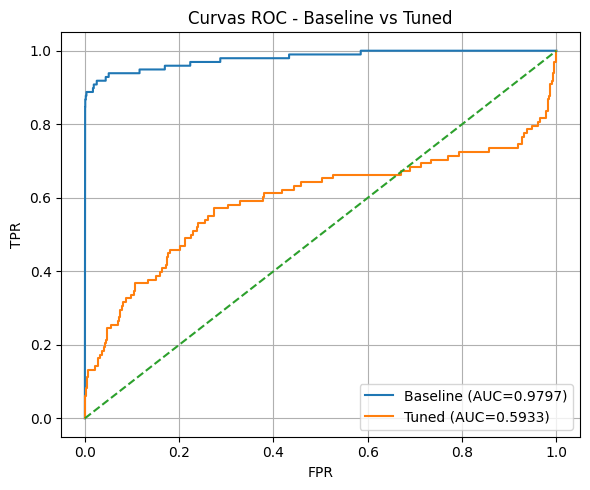


Arquivos salvos: metrics_comparison.csv, roc_curves.png, preds_baseline_vs_tuned.npz


In [18]:

from sklearn.metrics import roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Avaliação do melhor modelo (pós-Grid)
proba_best = best_tuned.predict_proba(X_test)[:, 1]
y_pred_best = (proba_best >= 0.5).astype(int)

metrics_best = {
    "accuracy": accuracy_score(y_test, y_pred_best),
    "precision": precision_score(y_test, y_pred_best, zero_division=0),
    "recall": recall_score(y_test, y_pred_best, zero_division=0),
    "f1": f1_score(y_test, y_pred_best, zero_division=0),
    "auc_roc": roc_auc_score(y_test, proba_best),
}

# Tabela de comparação
comp_df = pd.DataFrame([metrics_base, metrics_best], index=["Baseline NN", "Tuned NN"]).round(4)
display(comp_df)

# Confusion matrices
print("\nMatriz de confusão (Baseline):")
print(confusion_matrix(y_test, (proba_base>=0.5).astype(int)))
print("\nMatriz de confusão (Tuned):")
print(confusion_matrix(y_test, y_pred_best))

# Classification report (útil para observar Precision/Recall por classe)
print("\nRelatório de classificação (Baseline):")
print(classification_report(y_test, (proba_base>=0.5).astype(int), zero_division=0))
print("\nRelatório de classificação (Tuned):")
print(classification_report(y_test, y_pred_best, zero_division=0))

# Curvas ROC
fpr_b, tpr_b, _ = roc_curve(y_test, proba_base)
fpr_t, tpr_t, _ = roc_curve(y_test, proba_best)

plt.figure(figsize=(6, 5))
plt.plot(fpr_b, tpr_b, label=f"Baseline (AUC={metrics_base['auc_roc']:.4f})")
plt.plot(fpr_t, tpr_t, label=f"Tuned (AUC={metrics_best['auc_roc']:.4f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas ROC - Baseline vs Tuned")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curves.png", dpi=150)
plt.show()

# Salva resultados
comp_df.to_csv("metrics_comparison.csv", index=True)
np.savez("preds_baseline_vs_tuned.npz", proba_base=proba_base, proba_best=proba_best, y_test=y_test)
print("\nArquivos salvos: metrics_comparison.csv, roc_curves.png, preds_baseline_vs_tuned.npz")



### Análise dos Resultados — Baseline vs Tuned

Ao comparar os dois modelos, a diferença é bastante evidente. O **baseline** apresentou uma performance muito superior, com **AUC de 0.9797**, enquanto o modelo **tuned** despencou para apenas 0.5933, valor pouco acima de um classificador aleatório. Visualmente, a curva ROC do baseline se manteve próxima do ideal, enquanto a do modelo otimizado mal se afastou da diagonal de referência.

Nas métricas clássicas, o baseline alcançou **accuracy de 0.9879** e um **recall altíssimo de 0.8878** para a classe fraude, o que significa que quase todas as fraudes foram corretamente identificadas. A contrapartida foi a precisão baixa (0.1136), indicando muitos falsos positivos, mas ainda assim o modelo conseguiu cumprir bem a função de “pegar fraudes” — essencial em cenários financeiros, onde é melhor investigar alertas falsos do que deixar uma fraude real passar.

O modelo tuned, por outro lado, teve um desempenho desastroso: **accuracy caiu para 0.7019**, a precisão praticamente zerou (0.0033) e o F1 ficou em 0.0066. Na matriz de confusão isso se reflete em mais de **16 mil falsos positivos**, contra apenas 56 fraudes detectadas, deixando 42 passarem batidas. Isso o torna impraticável, já que um time antifraude jamais conseguiria lidar com esse volume de alarmes inúteis.

Na prática, minha leitura é que a tentativa de otimização dos hiperparâmetros não foi bem-sucedida. O baseline, mesmo simples, já estava calibrado para o problema e entregou um resultado sólido. O tuned sofreu provavelmente por conta da redução exagerada no espaço de busca, no tamanho do conjunto de treino ou no número de épocas, o que prejudicou sua capacidade de generalizar. Para fraude, o baseline é claramente a melhor escolha: recall alto e robustez na separação. O tuned gera mais ruído do que valor.

